In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
from func import path, path_img, get_data, show_images_horizontally, show_image
from func_torch import ShopeeDataset, device, torch, f1_score_cal
from torch.utils.data import DataLoader
from sklearn.neighbors import NearestNeighbors
from efficientnet_pytorch import EfficientNet
import gc

In [2]:
# input
df = get_data(path / 'train.csv', path_img)
df.head()

,posting_id,image,image_phash,title,label_group,filepath,target,title_edit
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_2278313361, train_129225211]",paper bag victoria secret
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_3386243561, train_3423213080]","double tape 3m vhb 12 mm x 4,5 m original / do..."
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_3803689425, train_2288590299]",maling tts canned pork luncheon meat 397 gr
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_3342059966, train_2406599165]",daster batik lengan pendek - motif acak / camp...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_921438619, train_3369186413]",nescafe \xc3\x89clair latte 220ml


In [3]:
dataset_data = ShopeeDataset(csv=df, train=True)
data_loader = DataLoader(dataset_data, batch_size=16, num_workers=4)

print(f"Dataset Len: {len(dataset_data):,}\nImage Shape [0]: {dataset_data[0][0].shape}")

Dataset Len: 34,250
Image Shape [0]: torch.Size([3, 512, 512])


In [4]:
model_name = 'efficientnet-b3'
image_embeddings_path = path / f'image_embed_{model_name}_pretrain.npy'
rerun = False

if rerun:
    # Run
    model_effnet = EfficientNet.from_name(model_name).to(device)
    print(model_name, device)

    embeddings = []
    with torch.no_grad():
        for image, label in tqdm(data_loader):
            image = image.to(device)
            img_embeddings = model_effnet(image)
            img_embeddings = img_embeddings.detach().cpu().numpy()
            embeddings.append(img_embeddings)
    all_image_embeddings = np.concatenate(embeddings)
    print(f"image_embeddings shape: {all_image_embeddings.shape}")

    # Save
    np.save(image_embeddings_path, all_image_embeddings)

    # Clean memory
    del model_effnet
    _ = gc.collect()
    
else:
    # load
    all_image_embeddings = np.load(image_embeddings_path)

In [5]:
knn_model = NearestNeighbors(n_neighbors=50)
knn_model.fit(all_image_embeddings)

predictions = []
print('Finding Similar Images ...')

distances, indices = knn_model.kneighbors(all_image_embeddings)
for k in tqdm(range(all_image_embeddings.shape[0])):
    index = np.where(distances[k, ] < 21.0)[0]
    split = indices[k, index]
    pred = df.iloc[split]['posting_id'].values.tolist()
    predictions.append(pred)

Finding Similar Images ...


100%|█████████████████████████████████████████████████████████████████████████| 34250/34250 [00:03<00:00, 10565.40it/s]


In [6]:
thresholds = list(np.arange(0.001, 0.1, 0.01))
target = df['target'].values.tolist()
scores, plot_check, f1_score_lst, pred_lst = {}, {}, [], {}

for num in thresholds:
    predictions = []
    for k in range(all_image_embeddings.shape[0]):
        idx = np.where(distances[k,] < num)[0]
        ids = indices[k,idx]
        predictions.append(df['posting_id'].iloc[ids].values.tolist())
    f1_score_lst = [f1_score_cal(i, v) for i, v in zip(target, predictions)]
    
    score = np.mean(f1_score_lst)
    scores.update({num: score})
    plot_check.update({num: f1_score_lst})
    pred_lst.update({num: predictions})
    print(f'--- F1 score for threshold {num} is {score:.3f} ---\n')

    
best_score = max(scores, key=scores.get)
print(f'--- Best score is {round(scores[best_score], 4)} and has a threshold {best_score} ---')
df['img_pred'] = pred_lst[best_score]
df['f1_score'] = plot_check[best_score]

--- F1 score for threshold 0.001 is 0.461 ---

--- F1 score for threshold 0.011 is 0.461 ---

--- F1 score for threshold 0.020999999999999998 is 0.461 ---

--- F1 score for threshold 0.030999999999999996 is 0.461 ---

--- F1 score for threshold 0.040999999999999995 is 0.461 ---

--- F1 score for threshold 0.05099999999999999 is 0.461 ---

--- F1 score for threshold 0.06099999999999999 is 0.461 ---

--- F1 score for threshold 0.071 is 0.461 ---

--- F1 score for threshold 0.08099999999999999 is 0.461 ---

--- F1 score for threshold 0.09099999999999998 is 0.461 ---

--- Best score is 0.4608 and has a threshold 0.001 ---


In [7]:
df.head()

,posting_id,image,image_phash,title,label_group,filepath,target,title_edit,img_pred,f1_score
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_2278313361, train_129225211]",paper bag victoria secret,[train_129225211],0.666667
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_3386243561, train_3423213080]","double tape 3m vhb 12 mm x 4,5 m original / do...",[train_3386243561],0.666667
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_3803689425, train_2288590299]",maling tts canned pork luncheon meat 397 gr,[train_2288590299],0.666667
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_3342059966, train_2406599165]",daster batik lengan pendek - motif acak / camp...,[train_2406599165],0.666667
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_921438619, train_3369186413]",nescafe \xc3\x89clair latte 220ml,[train_3369186413],0.666667


Text(0, 0.5, '')

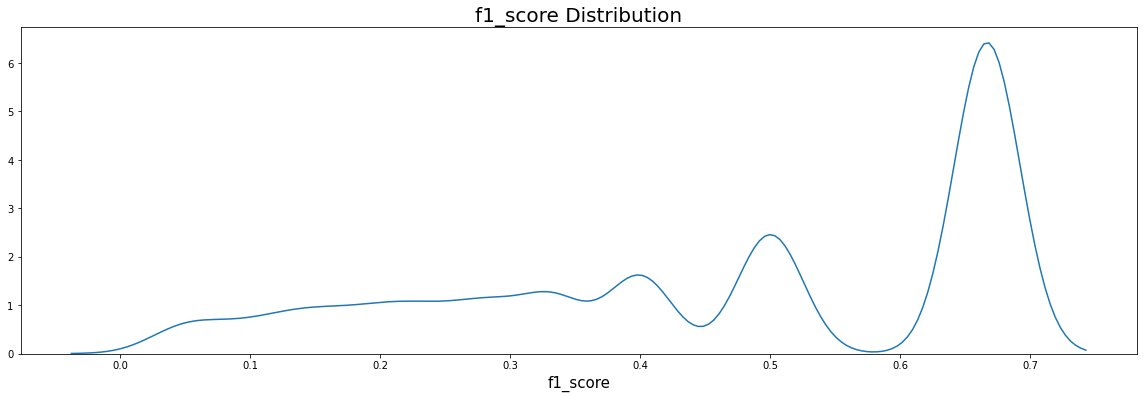

In [8]:
plt.figure(figsize = (20, 6))

plot = sns.kdeplot(x = df["f1_score"])
plt.title("f1_score Distribution", fontsize=20)
plt.xlabel("f1_score", fontsize=15)
plt.ylabel("")

In [9]:
test_id = 'train_3386243561'
df.query(f'posting_id == "{test_id}"')

,posting_id,image,image_phash,title,label_group,filepath,target,title_edit,img_pred,f1_score
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_3386243561, train_3423213080]","double tape 3m vhb 12 mm x 4,5 m original / do...",[train_3386243561],0.666667


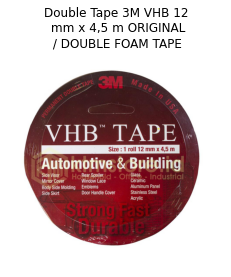

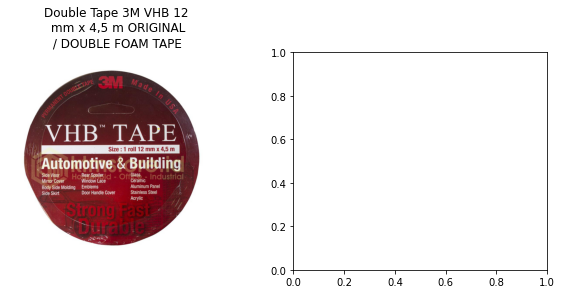

In [10]:
subset = df.query(f'posting_id == "{test_id}"')[['filepath', 'title']]
tuples = tuple(subset.to_numpy()[0])
show_image(tuples)

tmp = pd.DataFrame(df.query(f'posting_id == "{test_id}"')['img_pred'].item(), columns=['posting_id'])
tmp = tmp.merge(df[['posting_id', 'filepath', 'title']], how='left', on='posting_id')
tuples = [tuple(i) for i in tmp[['filepath', 'title']].to_numpy()]

show_images_horizontally(tuples)

In [12]:
# df[['posting_id', 'img_pred', 'f1_score']].to_feather(path / 'img_pred.ftr')